In [9]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import des_functions as des
from more_itertools import locate

datdir = '/home/b7009348/WGL_project/DES-data/'
matched = 'y1_mcal_shapes_matched.fits'
full = 'y1_mcal_flags=0.fits'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

### First we will load just the SNR data and investigate how different signal to nosie cuts affect the distributions
- I'm going to make some histograming and cutting functions to expediate this process

In [2]:
def cut_data(data, dat_min, dat_max):
    
    print('Locating cut...')
    indexes = list(locate(data, lambda x: dat_min <= x <= dat_max))
    print('Located, slicing data...')
    data = data[indexes]
    
    return data

In [169]:
def gram_it(full_data, cut_data, nbins, plot_it=True):
    
    fullCounts, fullBins = np.histogram(full_data, bins=np.logspace(np.log10(np.min(full_data)), np.log10(np.max(full_data)), nbins))
    
    cutCounts, cutBins = np.histogram(cut_data, bins=np.logspace(np.log10(np.min(cut_data)), np.log10(np.max(cut_data)), nbins))
    
    if plot_it==True:
        plt.stairs(fullCounts, fullBins, color='blue')
        plt.stairs(cutCounts, cutBins, color='orange')
        plt.axvline(np.mean(cut_data), color='orange')
        plt.axvline(np.mean(full_data), color='blue')
        plt.xscale('log')
        plt.legend(['Full', 'Cut'])
        plt.show()
        
    return fullCounts, fullBins, cutCounts, cutBins

In [7]:
with fits.open(datdir+full) as hdu:
    data = hdu[1].data
    full_snr = data['snr']
    del data

with fits.open(datdir+matched) as hdu:
    data = hdu[1].data
    match_snr = data['snr']
    del data

In [172]:
print(np.median(full_snr), np.median(match_snr))

23.028140200918877 28.10663231069848


In [145]:
print(np.max(match_snr), np.max(full_snr))

974749.8409404345 8208694.963290713


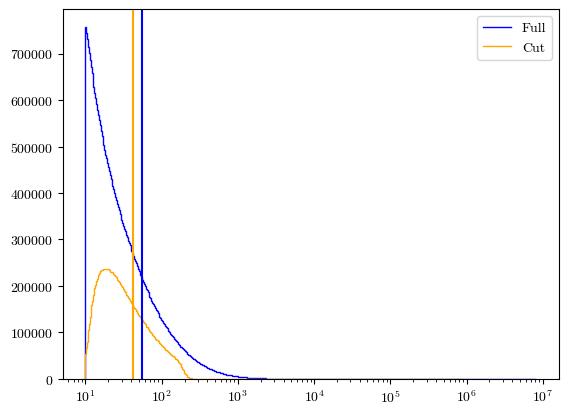

In [170]:
hist_data = zip(gram_it(full_snr, match_snr, 500))

### Functions are set up, so now we can start experimenting with different cuts
- Based off above plot, it looks like cutting below a signal to noise of 30 might approximate it

In [17]:
snr_30 = cut_data(full_snr, 30., np.inf)

Locating cut...
Located, slicing data...


In [20]:
print(np.size(match_snr),np.size(snr_30))

17814587 13756351


- Ok this is actually too small, so I can be more lenient

In [22]:
snr_20 = cut_data(full_snr, 20., np.inf)
print(np.size(match_snr),np.size(snr_20))

Locating cut...
Located, slicing data...
17814587 19668751


- getting closer..

In [25]:
snr_22p5 = cut_data(full_snr, 22.5, np.inf)
print(np.size(match_snr), np.size(snr_22p5))

Locating cut...
Located, slicing data...
17814587 17775174


#### This looks reasonable, so now lets plot it

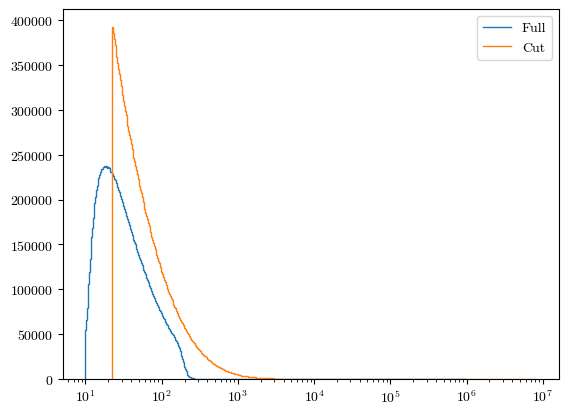

In [26]:
snr22p5_hist = zip(gram_it(match_snr, snr_22p5, 500))

- Ok, we have a similar size but the distributions are clearly different

In [27]:
print(np.mean(match_snr), np.mean(snr_22p5))

42.3329161710491 94.5905667897201


In [90]:
del snr_30, snr_20, snr_22p5, snr22p5_hist

- Can we get closer to the mean by being smarter about our cut?

In [60]:
snr_esti = cut_data(full_snr, 18.5, 116.)
print(np.size(match_snr), np.size(snr_esti))
print(np.mean(match_snr), np.mean(snr_esti))
print(np.std(match_snr), np.std(snr_esti))

Locating cut...
Located, slicing data...
17814587 17803545
42.3329161710491 42.81657012040434
422.58429144105503 23.64352292506715


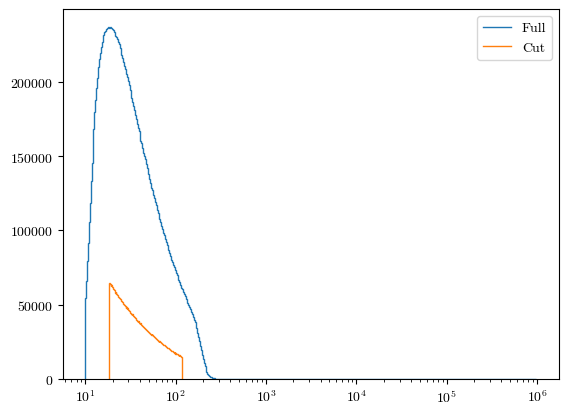

In [58]:
matchCounts, matchBins, cutCounts, cutBins = gram_it(match_snr, snr_esti, 500)

In [59]:
print(np.sum(matchCounts), np.sum(cutCounts))

17814586 17803543


### Ok, lets start trying to characterise a selection bias based on 18.5 <= SNR <= 116

In [79]:
with fits.open(datdir+full) as hdu:
    data = hdu[1].data

min_snr = 18.5
max_snr = 116.
delGamma = 0.01

print('Locating cut on unsheared images...')
unshear_indexes = list(locate(data['snr'], lambda x: min_snr <= x <= max_snr))
print('Slicing R11 and R22...')
R11 = data['R11'][unshear_indexes]
R22 = data['R22'][unshear_indexes]
del unshear_indexes
    
print('Locating cut on positively sheared images...')
p1_indexes = list(locate(data['snr_1p'], lambda x: min_snr <= x <= max_snr))
print('Slicing unsheared ellipticities...')
e1_s1p = data['e1'][p1_indexes]
del p1_indexes

print('Locating cut on negatively sheared images...')
m1_indexes = list(locate(data['snr_1m'], lambda x: min_snr <= x <= max_snr))
print('Slicing unsheared ellipticities...')
e1_s1m = data['e1'][m1_indexes]
del m1_indexes

Rs1 = (np.mean(e1_s1p) - np.mean(e1_s1m)) / delGamma
print('Rs1 calculated, proceding with Rs2...')

print('Locating cut on positively sheared images...')
p2_indexes = list(locate(data['snr_2p'], lambda x: min_snr <= x <= max_snr))
print('Slicing unsheared ellipticities...')
e2_s2p = data['e2'][p2_indexes]
del p2_indexes

print('Locating cut on negatively sheared images...')
m2_indexes = list(locate(data['snr_2m'], lambda x: min_snr <= x <= max_snr))
print('Slicing unsheared ellipticities...')
e2_s2m = data['e2'][m2_indexes]
del m2_indexes

Rs2 = (np.mean(e2_s2p) - np.mean(e2_s2m)) / delGamma
print('Rs2 calculated, process complete.')
del data

Locating cut on unsheared images...
Slicing R11 and R22...
Locating cut on positively sheared images...
Slicing unsheared ellipticities...
Locating cut on negatively sheared images...
Slicing unsheared ellipticities...
Rs1 calculated, proceeding with Rs2...
Locating cut on positively sheared images...
Slicing unsheared ellipticities...
Locating cut on negatively sheared images...
Slicing unsheared ellipticities...
Rs2 calculated, process complete.


In [91]:
R11 = np.mean(R11)
R22 = np.mean(R22)
print('R11:',R11,'R22:',R22)
print('Rs1:',Rs1,'Rs2:',Rs2)

R11: 0.7274586244936387 R22: 0.7296751243982187
Rs1: -0.008618610901483536 Rs2: -0.008568324201195786


In [93]:
print('Total response:')
print('R11:', R11+Rs1, 'R22:', R22+Rs2)
print('Percentage of total response due to selection:')
print('R11:',abs(Rs1/(R11+Rs1)) * 100., 'R22:', abs(Rs2/(R22+Rs2)) * 100.)

Total response:
R11: 0.7188400135921552 R22: 0.7211068001970229
Percentage of total response due to selection:
R11: 1.1989609285124514 R22: 1.188218471779038


In [82]:
with fits.open(datdir+matched) as hdu:
    data = hdu[1].data
    R11m = np.mean(data['R11'])
    R22m = np.mean(data['R22'])
print(R11m, R22m)

### Now lets repeat this process for r-band flux

In [94]:
with fits.open(datdir+full) as hdu:
    data = hdu[1].data
    full_rflux = data['flux_r']
    del data

with fits.open(datdir+matched) as hdu:
    data = hdu[1].data
    match_rflux = data['flux_r']
    del data

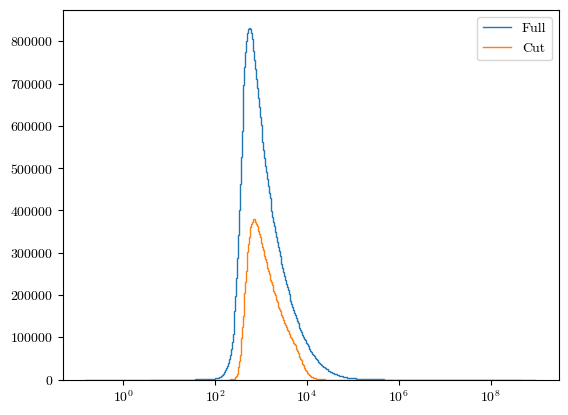

In [95]:
binit = zip(gram_it(full_rflux, match_rflux, 500))

In [120]:
rflux_cut = cut_data(full_rflux, 712., 5450.)
print(np.size(match_rflux),np.size(rflux_cut))
print(np.mean(match_rflux), np.mean(rflux_cut))
print(np.std(match_rflux), np.std(rflux_cut))

Locating cut...
Located, slicing data...
17814587 17796291
1795.3262370496645 1795.1659069426935
149873.62909595398 1117.4361645875067


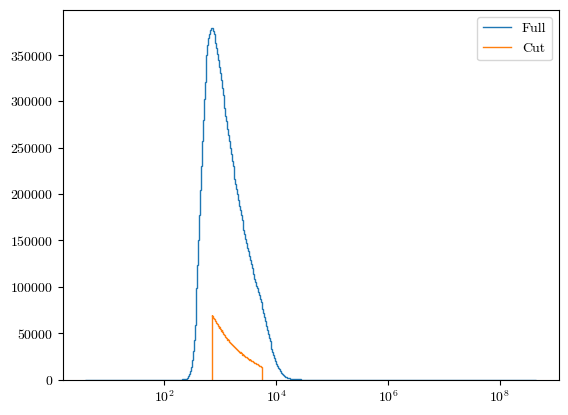

In [121]:
binit = zip(gram_it(match_rflux, rflux_cut, 500))

In [123]:
with fits.open(datdir+full) as hdu:
    data = hdu[1].data

min_rflux = 712.
max_rflux = 5450.
delGamma = 0.01

print('Locating cut on unsheared images...')
unshear_indexes = list(locate(data['flux_r'], lambda x: min_rflux <= x <= max_rflux))
print('Slicing R11 and R22...')
R11 = data['R11'][unshear_indexes]
R22 = data['R22'][unshear_indexes]
del unshear_indexes
    
print('Locating cut on positively sheared images...')
p1_indexes = list(locate(data['flux_r_1p'], lambda x: min_rflux <= x <= max_rflux))
print('Slicing unsheared ellipticities...')
e1_s1p = data['e1'][p1_indexes]
del p1_indexes

print('Locating cut on negatively sheared images...')
m1_indexes = list(locate(data['flux_r_1m'], lambda x: min_rflux <= x <= max_rflux))
print('Slicing unsheared ellipticities...')
e1_s1m = data['e1'][m1_indexes]
del m1_indexes

Rs1 = (np.mean(e1_s1p) - np.mean(e1_s1m)) / delGamma
print('Rs1 calculated, proceding with Rs2...')

print('Locating cut on positively sheared images...')
p2_indexes = list(locate(data['flux_r_2p'], lambda x: min_rflux <= x <= max_rflux))
print('Slicing unsheared ellipticities...')
e2_s2p = data['e2'][p2_indexes]
del p2_indexes

print('Locating cut on negatively sheared images...')
m2_indexes = list(locate(data['flux_r_2m'], lambda x: min_rflux <= x <= max_rflux))
print('Slicing unsheared ellipticities...')
e2_s2m = data['e2'][m2_indexes]
del m2_indexes

Rs2 = (np.mean(e2_s2p) - np.mean(e2_s2m)) / delGamma
print('Rs2 calculated, process complete.')
del data

Locating cut on unsheared images...
Slicing R11 and R22...
Locating cut on positively sheared images...
Slicing unsheared ellipticities...
Locating cut on negatively sheared images...
Slicing unsheared ellipticities...
Rs1 calculated, proceding with Rs2...
Locating cut on positively sheared images...
Slicing unsheared ellipticities...
Locating cut on negatively sheared images...
Slicing unsheared ellipticities...
Rs2 calculated, process complete.


In [124]:
R11 = np.mean(R11)
R22 = np.mean(R22)
print('R11:',R11,'R22:',R22)
print('Rs1:',Rs1,'Rs2:',Rs2)

R11: 0.7190375833253614 R22: 0.7211036708882648
Rs1: 0.0038208626142148734 Rs2: 0.003571330497525348


In [125]:
print('Total response:')
print('R11:', R11+Rs1, 'R22:', R22+Rs2)
print('Percentage of total response due to selection:')
print('R11:',abs(Rs1/(R11+Rs1)) * 100., 'R22:', abs(Rs2/(R22+Rs2)) * 100.)

Total response:
R11: 0.7228584459395763 R22: 0.7246750013857901
Percentage of total response due to selection:
R11: 0.5285768791493458 R22: 0.49281822757731697


In [127]:
with fits.open(datdir+matched) as hdu:
    data = hdu[1].data
    R11m = np.mean(data['R11'])
    R22m = np.mean(data['R22'])
print(R11m, R22m)

0.7130433641769826 0.7148120062326966


### Finally we will check the selection response for size

In [130]:
with fits.open(datdir+full) as hdu:
    data = hdu[1].data
    full_sizes = data['size']
    del data

with fits.open(datdir+matched) as hdu:
    data = hdu[1].data
    match_sizes = data['size']
    del data

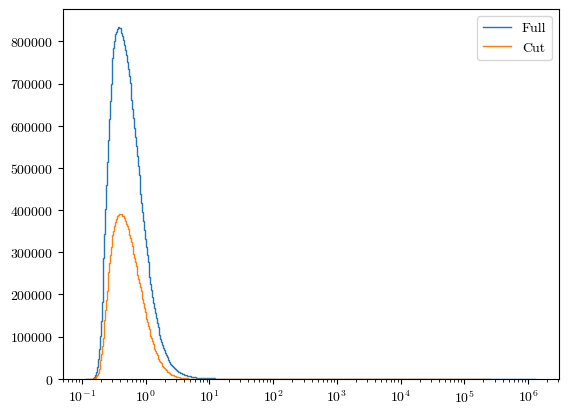

In [131]:
binit = zip(gram_it(full_sizes, match_sizes, 500))

In [142]:
size_cut = cut_data(full_sizes, 0.4, 1.06)
print(np.size(match_sizes),np.size(size_cut))
print(np.mean(match_sizes), np.mean(size_cut))
print(np.std(match_sizes), np.std(size_cut))

Locating cut...
Located, slicing data...
17814587 17810475
0.6274533337606691 0.6238679455938807
84.92865321047474 0.17293803064339744
